**5. Computing % of progressive passes made in each region by an LCB based on dominant foot**

A pass said to be progressive if:

    a. x_component (final pass location) - x_component (initial pass location) >= 30 if the starting and the finishing points of the pass lie within the team's own half
    
    b. x_component (final pass location) - x_component (initial pass location) >= 15 if the starting point of the pass lies within the team's own half while the finishing point lies in the opponent's half.
    
    c. x_component (final pass location) - x_component (initial pass location) >=10 if the starting and the finishing points lie within the opponent's half
    
This notebook showcases as to how different footed LCBs access various parts of the field differently during a progressive build up.

The following tasks have been taken into account in this notebook: (These tasks were performed for four defender and three/five defender formations seperately)

1. Segregate accurate progressive passes from accurate passes and plot the initial and the final pass locations of these passes

2. Divided the pitch into 8 regions:

     a. Right Flank Attack - x >= 52 and y <= 17
     
     b. Right Flank Defence - x < 52 and y <= 17
     
     c. Right Central Attack - x >= 52 and y > 17 and y <= 34
     
     d. Right Central Defence - x < 52 and y > 17 and y <= 34
     
     e. Left Central Attack - x >= 52 and y > 34 and y <= 51 
     
     f. Left Central Defence - x < 52 and y > 34 and y <= 51
     
     g. Left Flank Attack - x >= 52 and y > 51 and y <= 68
     
     h. Left Flank Defence - x < 52 and y > 51 and y <= 68
     
     
    and calculated the percentage of accurate progressive balls (i.e. number of accurate progressive balls in region/total number of accurate progressive balls) made in these regions.
    
3. Performed hypothesis testing to check if the results obtained were statistically significant

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('max_columns',100)

**Paths for cluster files for four defender formations**

In [18]:
base_path = "../data_top5/clusters/clusters_v3"
clusters = ['four_defs','three_five_defs']
files = [os.path.join(base_path,'cluster_' + cluster + '.pkl') for cluster in clusters]

**Reading cluster files**


In [19]:
df_clusters = list()
for file in files:
    df_clusters.append(pd.read_pickle(file))

**Reseting index of clusters**


In [20]:
for df in df_clusters:
    df.reset_index(inplace = True)

**Function to get start and end location points for every row in df**

In [21]:
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

**Function to apply progressive pass filter**

In [22]:
def distfilter(locs):
    loc_start, loc_end = getstartend(locs)
    prog_accpasslocs = list()
    for p1,p2 in zip(loc_start,loc_end):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and p2[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_accpasslocs.append([p1,p2])
        elif p1[0] > 52 and p2[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_accpasslocs.append([p1,p2])
        elif p1[0] < 52 and p2[0] > 52 and dist >= 15 and p1[0] < p2[0]:
            prog_accpasslocs.append([p1,p2])
    return prog_accpasslocs
            

**Creating progressive pass column for LCB in a four defender formation**


In [23]:
df_clusters_prog = list()
for df in df_clusters:
    if df['backline'][0] == 4:
        df['L_CB_progaccpassloc'] = df.apply(lambda x: distfilter(x['L_CB_accpassloc']),axis = 1)
    elif df['backline'][0] in [3,5]:
        df['LCB_progaccpassloc'] = df.apply(lambda x: distfilter(x['LCB_accpassloc']), axis = 1)
    df_clusters_prog.append(df)

**Function to get start and end location points for a whole df column**


In [24]:
def getstartendfull(locs):
    end_points = list()
    start_points = list()
    for match in locs:
        for point in match:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

**Counting number of progressive passes**


In [25]:
counter = 0
for df in df_clusters_prog:
    if df['backline'][0] in [3,5]:
        start,end = getstartendfull(df['LCB_progaccpassloc'])
        counter = counter + len(start)
    elif df['backline'][0] == 4:
        start,end = getstartendfull(df['L_CB_progaccpassloc'])
        counter = counter + len(start)
counter

46456

**Counting number of accurate passes**

In [26]:
counter_acc = 0
for df in df_clusters_prog:
    if df['backline'][0] in [3,5]:
        start,end = getstartendfull(df['LCB_accpassloc'])
        counter_acc = counter_acc + len(start)
    elif df['backline'][0] == 4:
        start,end = getstartendfull(df['L_CB_accpassloc'])
        counter_acc = counter_acc + len(start)
counter_acc

147140

**Saving the updated clusters as pickle files**

In [27]:
clusters = ['four_defs','three_five_defs']
for i, df in enumerate(df_clusters_prog):
    df.to_pickle(f'../data_top5/clusters/clusters_prog/cluster_prog_{clusters[i]}.pkl')

**Plotting the progressive passes**

In [28]:
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [29]:
def draw_pitch(line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
        circle4 = plt.Circle((93, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle5 = plt.Circle((11, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle6 = plt.Circle((52, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-', color="None", zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-', color='None', zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color="None", zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
        
    return fig, ax

In [30]:
def heatmap(x, y, title, c):
    fig, ax = draw_pitch("#000000","h","full")
    sns.kdeplot(x, y, cmap = c, shade = True)
    plt.title(title, fontsize = 30)
    plt.xlim(-1,105)
    plt.ylim(-1,69)
    plt.axis('off')
    plt.show()

**Plotting intial and final locations of progressive passes for LCBs in four defender formations**

In [36]:
df_four_defs = pd.read_pickle('../data_top5/clusters/clusters_prog/cluster_prog_four_defs.pkl')

In [37]:
four_defs_lcb_lf_clusters = df_four_defs[df_four_defs['footedness'].apply(lambda x: x.split('-')[-2]=='left')]
four_defs_lcb_rf_clusters = df_four_defs[df_four_defs['footedness'].apply(lambda x: x.split('-')[-2]=='right')]

In [38]:
four_defs_lcb_rf_proglist = four_defs_lcb_rf_clusters['L_CB_progaccpassloc'].tolist()

In [39]:
four_defs_lcb_rf_prog_start, four_defs_lcb_rf_prog_end = getstartendfull(four_defs_lcb_rf_proglist)

In [40]:
four_defs_lcb_rf_prog_start_x, four_defs_lcb_rf_prog_start_y = getxy(four_defs_lcb_rf_prog_start)

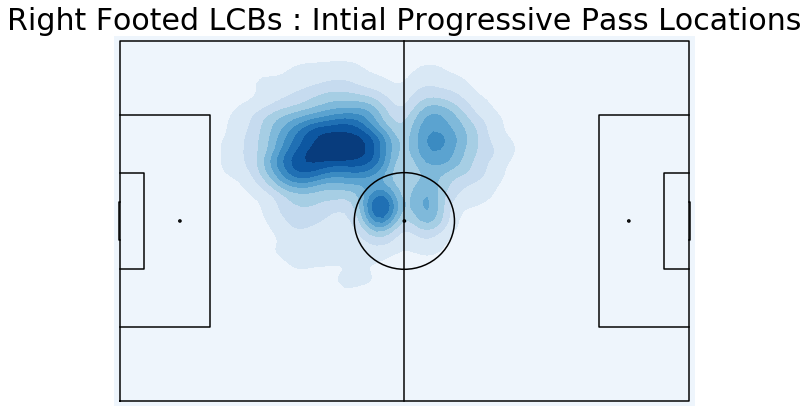

In [41]:
heatmap(four_defs_lcb_rf_prog_start_x, four_defs_lcb_rf_prog_start_y, 'Right Footed LCBs : Intial Progressive Pass Locations', 'Blues')

In [42]:
four_defs_lcb_rf_prog_end_x, four_defs_lcb_rf_prog_end_y = getxy(four_defs_lcb_rf_prog_end)
print(len(four_defs_lcb_rf_prog_end_x))

21289


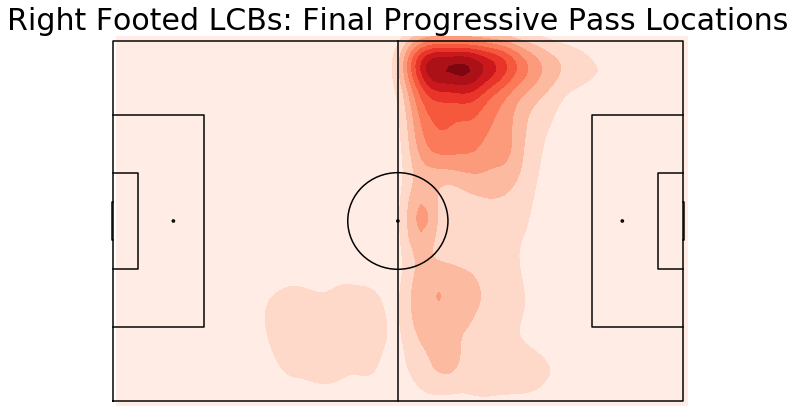

In [43]:
heatmap(four_defs_lcb_rf_prog_end_x, four_defs_lcb_rf_prog_end_y, 'Right Footed LCBs: Final Progressive Pass Locations', 'Reds')

In [44]:
four_defs_lcb_lf_proglist = four_defs_lcb_lf_clusters['L_CB_progaccpassloc'].tolist()

In [45]:
four_defs_lcb_lf_prog_start, four_defs_lcb_lf_prog_end = getstartendfull(four_defs_lcb_lf_proglist)

In [46]:
four_defs_lcb_lf_prog_start_x, four_defs_lcb_lf_prog_start_y = getxy(four_defs_lcb_lf_prog_start)
print(len(four_defs_lcb_lf_prog_start_x))

14475


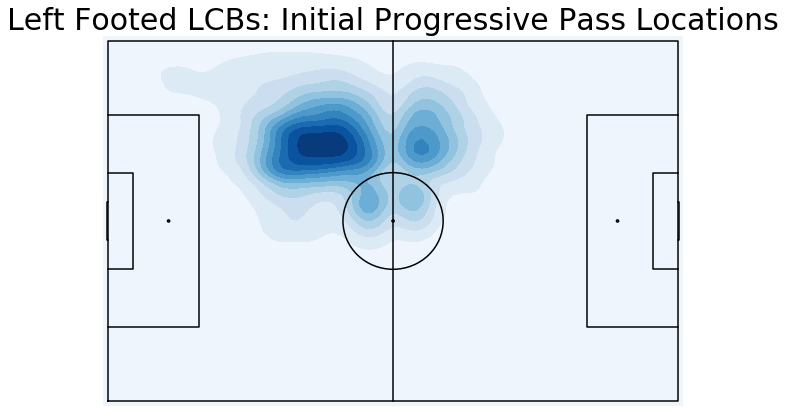

In [47]:
heatmap(four_defs_lcb_lf_prog_start_x, four_defs_lcb_lf_prog_start_y, 'Left Footed LCBs: Initial Progressive Pass Locations', 'Blues')

In [48]:
four_defs_lcb_lf_prog_end_x, four_defs_lcb_lf_prog_end_y = getxy(four_defs_lcb_lf_prog_end)

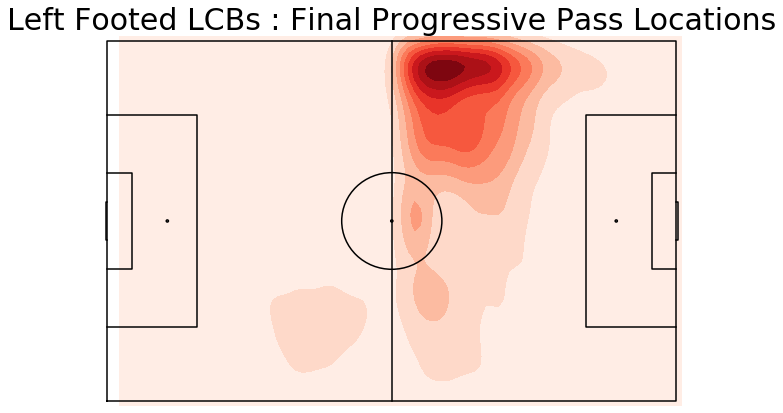

In [49]:
heatmap(four_defs_lcb_lf_prog_end_x, four_defs_lcb_lf_prog_end_y, 'Left Footed LCBs : Final Progressive Pass Locations', 'Reds')

**Plotting initial and final pass locations of progressive passes for LCBs in three/five defender formations**

In [52]:
def three_five_lcb_foot(row,foot):
    if row['backline']==3:
        return row['footedness'].split('-')[-1]==foot
    else:
        return row['footedness'].split('-')[-2]==foot

In [53]:
# Creating dataframes for clusters for 3 or 5 defender formations
df_three_five_defs = pd.read_pickle('../data_top5/clusters/clusters_prog/cluster_prog_three_five_defs.pkl')
three_five_defs_lcb_lf_clusters = df_three_five_defs[df_three_five_defs[['backline','footedness']].apply(lambda x : three_five_lcb_foot(x,'left'),axis=1)]
three_five_defs_lcb_rf_clusters = df_three_five_defs[df_three_five_defs[['backline','footedness']].apply(lambda x : three_five_lcb_foot(x,'right'),axis=1)]

In [54]:
three_five_lcb_lf_progpassloclist = three_five_defs_lcb_lf_clusters['LCB_progaccpassloc'].tolist()
three_five_lcb_rf_progpassloclist = three_five_defs_lcb_rf_clusters['LCB_progaccpassloc'].tolist()

In [56]:
three_five_lcb_lf_prog_start, three_five_lcb_lf_prog_end = getstartendfull(three_five_lcb_lf_progpassloclist)
three_five_lcb_rf_prog_start, three_five_lcb_rf_prog_end = getstartendfull(three_five_lcb_rf_progpassloclist)

In [57]:
three_five_lcb_lf_prog_start_x, three_five_lcb_lf_prog_start_y = getxy(three_five_lcb_lf_prog_start)
three_five_lcb_lf_prog_end_x, three_five_lcb_lf_prog_end_y = getxy(three_five_lcb_lf_prog_end)
three_five_lcb_rf_prog_start_x, three_five_lcb_rf_prog_start_y = getxy(three_five_lcb_rf_prog_start)
three_five_lcb_rf_prog_end_x, three_five_lcb_rf_prog_end_y = getxy(three_five_lcb_rf_prog_end)
print(len(three_five_lcb_lf_prog_start_x))
print(len(three_five_lcb_rf_prog_start_x))

6301
4391


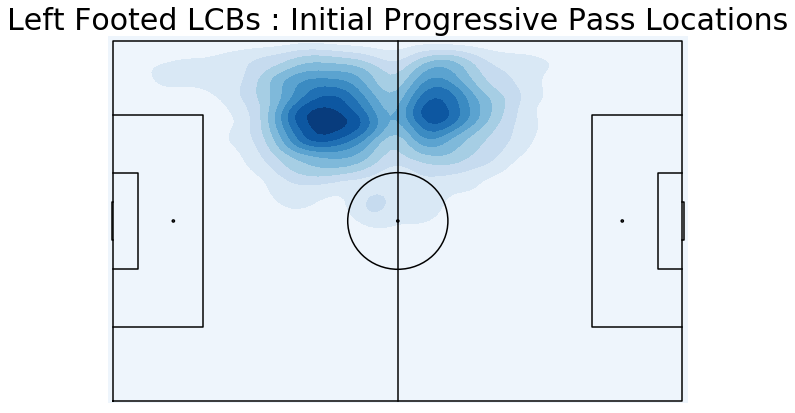

In [58]:
heatmap(three_five_lcb_lf_prog_start_x, three_five_lcb_lf_prog_start_y, 'Left Footed LCBs : Initial Progressive Pass Locations', 'Blues')

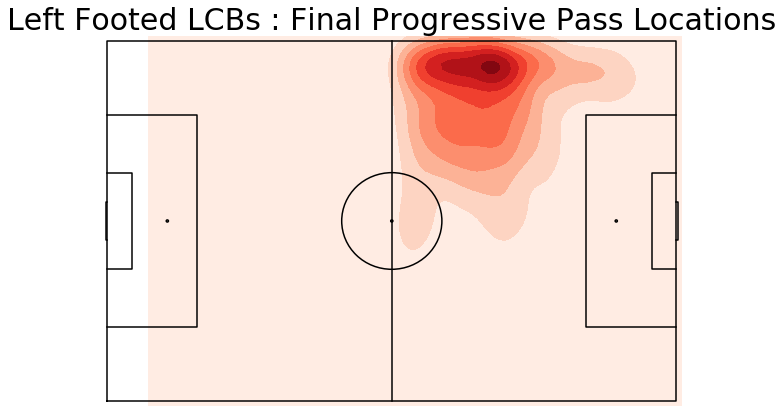

In [59]:
heatmap(three_five_lcb_lf_prog_end_x, three_five_lcb_lf_prog_end_y, 'Left Footed LCBs : Final Progressive Pass Locations', 'Reds')

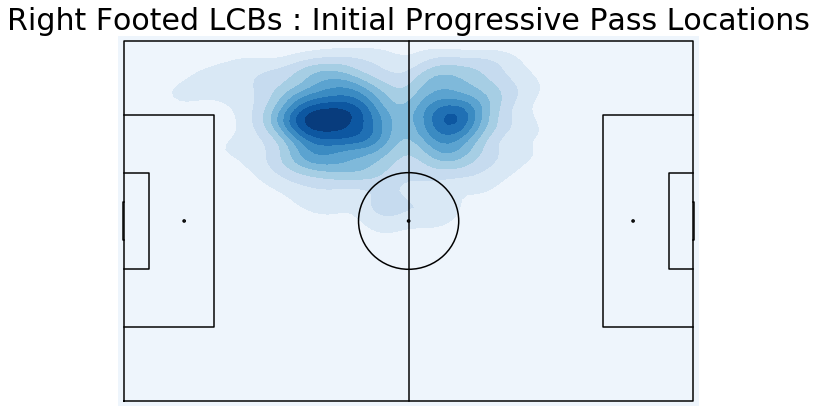

In [60]:
heatmap(three_five_lcb_rf_prog_start_x, three_five_lcb_rf_prog_start_y, 'Right Footed LCBs : Initial Progressive Pass Locations', 'Blues')

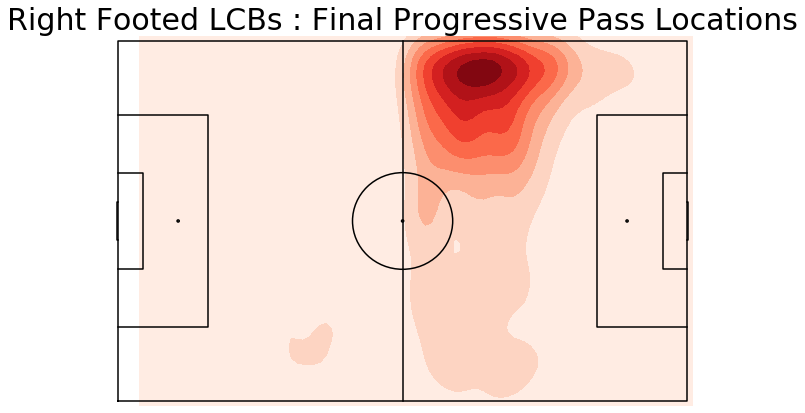

In [61]:
heatmap(three_five_lcb_rf_prog_end_x, three_five_lcb_rf_prog_end_y, 'Right Footed LCBs : Final Progressive Pass Locations', 'Reds')

**Finding percentage of progressive passes per region for LCBs in four defender formations**

Order:<br>percentage(x_rightflank_attack), percentage(x_rightflank_def), percentage(
        x_leftflank_attack), percentage(x_leftflank_def), percentage(
            x_rightcentral_attack), percentage(x_rightcentral_def), percentage(
                x_leftcentral_attack), percentage(x_leftcentral_def)

In [62]:
def get_region(x, y):

    x_rightflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    y_rightflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    x_rightflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]
    y_rightflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]

    x_leftflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    y_leftflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    x_leftflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]
    y_leftflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]

    x_rightcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    x_rightcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]

    x_leftcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    x_leftcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]

    return [len(x_rightflank_attack), len(x_rightflank_def), len(
        x_leftflank_attack), len(x_leftflank_def), len(
            x_rightcentral_attack), len(x_rightcentral_def), len(
                x_leftcentral_attack), len(x_leftcentral_def)]

In [63]:
four_lcb_rf_region = get_region(four_defs_lcb_rf_prog_end_x, four_defs_lcb_rf_prog_end_y)
print(four_lcb_rf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
four_lcb_rf_region_per = [i/len(four_defs_lcb_rf_prog_end_x)*100 for i in four_lcb_rf_region]
for region, percent in zip(regions,four_lcb_rf_region_per):
    print(region,":",percent)

[2873, 1781, 8678, 496, 2699, 790, 3833, 139]
rightflank_attack : 13.495232279581003
rightflank_def : 8.36582272535112
leftflank_attack : 40.762835267039314
leftflank_def : 2.3298417022875664
rightcentral_attack : 12.677908779181738
rightcentral_def : 3.710836582272535
leftcentral_attack : 18.004603316266614
leftcentral_def : 0.6529193480201043


In [64]:
four_lcb_lf_region = get_region(four_defs_lcb_lf_prog_end_x, four_defs_lcb_lf_prog_end_y)
print(four_lcb_lf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
four_lcb_lf_region_per = [i/len(four_defs_lcb_lf_prog_end_x)*100 for i in four_lcb_lf_region]
for region, percent in zip(regions,four_lcb_lf_region_per):
    print(region,":",percent)

[1265, 880, 6513, 363, 1699, 535, 3090, 130]
rightflank_attack : 8.739205526770293
rightflank_def : 6.079447322970639
leftflank_attack : 44.99481865284974
leftflank_def : 2.5077720207253886
rightcentral_attack : 11.73747841105354
rightcentral_def : 3.696027633851468
leftcentral_attack : 21.34715025906736
leftcentral_def : 0.8981001727115717


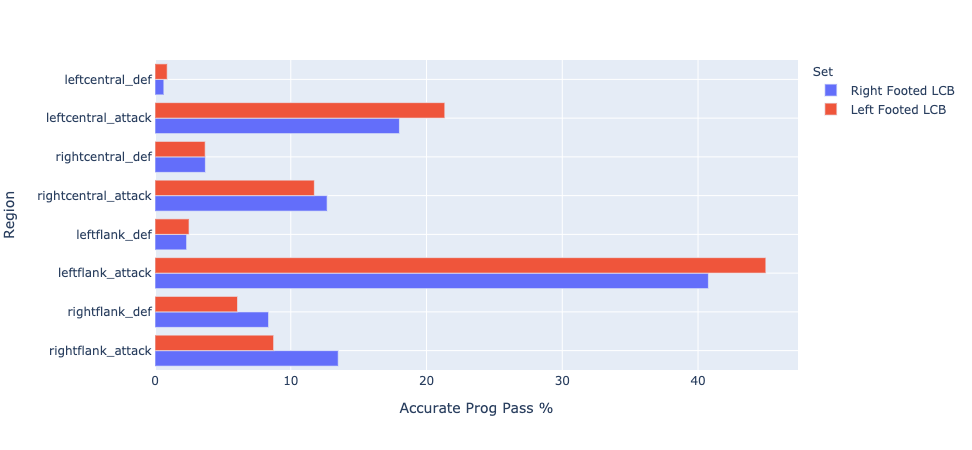

In [66]:
# data_reg = [['Right Flank Attack', 16.348577601728483, 'RRRL'],
#             ['Right Flank Attack',10.58601134215501, 'RRLL'],
#             ['Right Flank Def', 10.875045012603529, 'RRRL'],
#             ['Right Flank Def', 6.301197227473219, 'RRLL'],
#             ['Left Flank Attack', 37.27043572200216, 'RRRL'],
#             ['Left Flank Attack', 43.28922495274102, 'RRLL'],
#             ['Left Flank Def', 3.456967951026287, 'RRRL'],
#             ['Left Flank Def', 2.898550724637681, 'RRLL'],
#             ['Right Central Attack', 12.171407994238386, 'RRRL'],
#             ['Right Central Attack', 12.917454316320102, 'RRLL'],
#             ['Right Central Def', 6.1937342455887645, 'RRRL'],
#             ['Right Central Def', 5.16698172652804, 'RRLL'],
#             ['Left Central Attack', 13.215700396110911, 'RRRL'],
#             ['Left Central Attack', 18.021424070573406, 'RRLL'],
#             ['Left Central Def', 0.4681310767014764, 'RRRL'],
#             ['Left Central Def', 0.8191556395715185, 'RRLL']]
four_def_lcbs_rf_data = list(zip(regions,four_lcb_rf_region_per))
four_def_lcbs_rf_data_reg = [list(i) + ["Right Footed LCB"] for i in four_def_lcbs_rf_data]
four_def_lcbs_lf_data = list(zip(regions,four_lcb_lf_region_per))
four_def_lcbs_lf_data_reg = [list(i) + ["Left Footed LCB"] for i in four_def_lcbs_lf_data]
data_reg = four_def_lcbs_rf_data_reg + four_def_lcbs_lf_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Prog Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Prog Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

**Finding percentage of progressive passes per region for LCBs in three/five defender formations**

In [67]:
three_five_lcb_lf_region = get_region(three_five_lcb_lf_prog_end_x, three_five_lcb_lf_prog_end_y)
print(three_five_lcb_lf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
three_five_lcb_lf_region_per = [i/len(three_five_lcb_lf_prog_end_x)*100 for i in three_five_lcb_lf_region]
for region, percent in zip(regions,three_five_lcb_lf_region_per):
    print(region,":",percent)

[338, 185, 3480, 110, 536, 127, 1475, 50]
rightflank_attack : 5.3642279003332805
rightflank_def : 2.936041898111411
leftflank_attack : 55.229328677987624
leftflank_def : 1.7457546421202983
rightcentral_attack : 8.506586256149816
rightcentral_def : 2.015553086811617
leftcentral_attack : 23.408982701158546
leftcentral_def : 0.7935248373274084


In [68]:
three_five_lcb_rf_region = get_region(three_five_lcb_rf_prog_end_x, three_five_lcb_rf_prog_end_y)
print(three_five_lcb_rf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
three_five_lcb_rf_region_per = [i/len(three_five_lcb_rf_prog_end_x)*100 for i in three_five_lcb_rf_region]
for region, percent in zip(regions,three_five_lcb_rf_region_per):
    print(region,":",percent)

[472, 257, 2165, 77, 417, 101, 869, 33]
rightflank_attack : 10.749259849692553
rightflank_def : 5.85288089273514
leftflank_attack : 49.30539740378046
leftflank_def : 1.7535868822591665
rightcentral_attack : 9.496697790936006
rightcentral_def : 2.3001594169892963
leftcentral_attack : 19.79048052835345
leftcentral_def : 0.7515372352539286


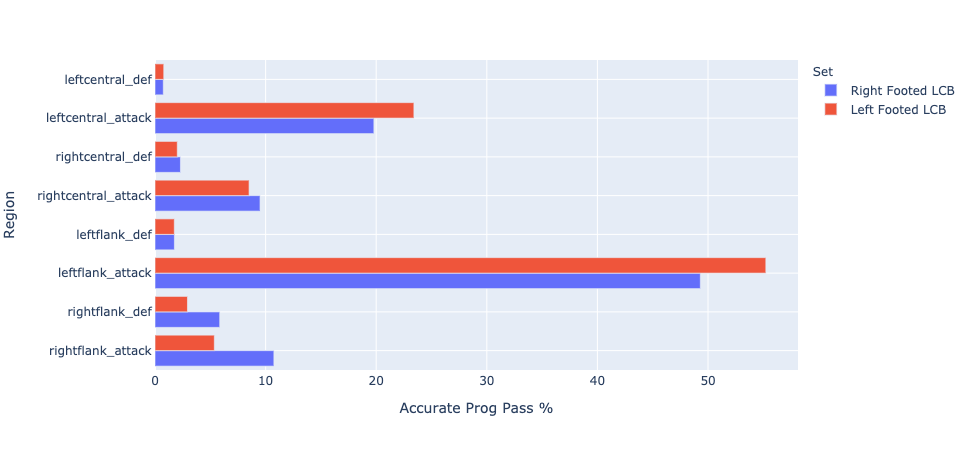

In [69]:
# data_reg = [['Right Flank Attack', 7.2727272727272725, 'RRRL'],
#             ['Right Flank Attack',10.58601134215501, 'RRLL'],
#             ['Right Flank Def', 10.875045012603529, 'RRRL'],
#             ['Right Flank Def', 6.301197227473219, 'RRLL'],
#             ['Left Flank Attack', 37.27043572200216, 'RRRL'],
#             ['Left Flank Attack', 43.28922495274102, 'RRLL'],
#             ['Left Flank Def', 3.456967951026287, 'RRRL'],
#             ['Left Flank Def', 2.898550724637681, 'RRLL'],
#             ['Right Central Attack', 12.171407994238386, 'RRRL'],
#             ['Right Central Attack', 12.917454316320102, 'RRLL'],
#             ['Right Central Def', 6.1937342455887645, 'RRRL'],
#             ['Right Central Def', 5.16698172652804, 'RRLL'],
#             ['Left Central Attack', 13.215700396110911, 'RRRL'],
#             ['Left Central Attack', 18.021424070573406, 'RRLL'],
#             ['Left Central Def', 0.4681310767014764, 'RRRL'],
#             ['Left Central Def', 0.8191556395715185, 'RRLL']]
three_five_lcb_lf_data = list(zip(regions,three_five_lcb_lf_region_per))
three_five_lcb_lf_data_reg = [list(i) + ["Left Footed LCB"] for i in three_five_lcb_lf_data]
three_five_lcb_rf_data = list(zip(regions,three_five_lcb_rf_region_per))
three_five_lcb_rf_data_reg = [list(i) + ["Right Footed LCB"] for i in three_five_lcb_rf_data]
data_reg = three_five_lcb_rf_data_reg + three_five_lcb_lf_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Prog Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Prog Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

**Performing Hypothesis Testing for difference of percentage of passes made by left and right footed LCBs in Right Flank, Left Flank and Central Region for four defender formations (Significance level : 0.05)**

## Right - Flank

**Null Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be greater than or equal to right footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be less than right footed LCB (left center back) in a lineup with four defenders

**H0: P2 >= P1** <br>
**H1: P2 < P1** <br>
*P1 - Right Footed LCBs, P2 - Left Footed LCBs*

**The hypothesis stated signifies that we are performing a right tailed test**

In [70]:
# Right Flank HT

from statsmodels.stats.proportion import proportions_ztest
count = np.array([four_lcb_rf_region[0] + four_lcb_rf_region[1], four_lcb_lf_region[0] + four_lcb_lf_region[1]])
nobs = np.array([len(four_defs_lcb_rf_prog_end_x),len(four_defs_lcb_lf_prog_end_x)] )
stat, pval = proportions_ztest(count, nobs, alternative ='larger')
print(stat, pval)

16.659865658899605 1.2830008187475152e-62


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Left - Flank

**Null Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be greater than or equal to left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be lesser than left footed LCB (left center back) in a lineup with four defenders

**H0: P1 >= P2** <br>
**H1: P1 < P2** <br>
*P1 - Right Footed LCBs, P2 - Left Footed LCBs*

**The hypothesis stated signifies that we are performing a left tailed test**

In [71]:
# Left Flank HT
from statsmodels.stats.proportion import proportions_ztest
count = np.array([four_lcb_rf_region[2] + four_lcb_rf_region[3], four_lcb_lf_region[2] + four_lcb_lf_region[3]])
nobs = np.array([len(four_defs_lcb_rf_prog_end_x),len(four_defs_lcb_lf_prog_end_x) ])
stat, pval = proportions_ztest(count, nobs, alternative ='smaller')
print(stat, pval)

-8.230290354063971 9.338009706799172e-17


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Central - Region

**Null Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should be equal to that of left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should not be equal to that of left footed LCB (left center back) in a lineup with four defenders

**H0: P1 = P2** <br>
**H1: P1 != P2** <br>
*P1 - Right Footed LCBs, P2 - Left Footed LCBs*

In [72]:
# Central Region HT
count = np.array([four_lcb_rf_region[4] + four_lcb_rf_region[5] + four_lcb_rf_region[6] + four_lcb_rf_region[7], 
                  four_lcb_lf_region[4] + four_lcb_lf_region[5] + four_lcb_lf_region[6] + four_lcb_lf_region[7]])
nobs = np.array([len(four_defs_lcb_rf_prog_end_x), len(four_defs_lcb_lf_prog_end_x)])
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-5.087397014170398 3.630113943293562e-07


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

**Performing Hypothesis Testing for difference in percentage of passes made by left and right footed LCBs in Right Flank, Left Flank and Central Region for three/five defender formations (Significance Level : 0.05)**

## Right - Flank

**Null Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be greater than or equal to right footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be less than right footed LCB (left center back) in a lineup with three/five defenders

**H0: P2 >= P1** <br>
**H1: P2 < P1** <br>
*P1 - Right Footed LCB, P2 - Left Footed LCB*

**The hypothesis stated signifies that we are performing a right tailed test**

In [75]:
# Right Flank HT

from statsmodels.stats.proportion import proportions_ztest
count = np.array([three_five_lcb_rf_region[0] + three_five_lcb_rf_region[1], three_five_lcb_lf_region[0] + three_five_lcb_lf_region[1]])
nobs = np.array([len(three_five_lcb_rf_prog_end_x),len(three_five_lcb_lf_prog_end_x)] )
stat, pval = proportions_ztest(count, nobs, alternative ='larger')
print(stat, pval)

13.13420376328085 1.0484269408023147e-39


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Left - Flank

**Null Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be greater than or equal to left footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be lesser than left footed LCB (left center back) in a lineup with three/five defenders

**H0: P1 >= P2** <br>
**H1: P1 < P2** <br>
*P1 - Right Footed LCB, P2 - Left Footed LCB*

**The hypothesis stated signifies that we are performing a left tailed test**

In [76]:
# Left Flank HT
from statsmodels.stats.proportion import proportions_ztest
count = np.array([three_five_lcb_rf_region[2] + three_five_lcb_rf_region[3], three_five_lcb_lf_region[2] + three_five_lcb_lf_region[3]])
nobs = np.array([len(three_five_lcb_rf_prog_end_x),len(three_five_lcb_lf_prog_end_x) ])
stat, pval = proportions_ztest(count, nobs, alternative ='smaller')
print(stat, pval)

-6.044000289738614 7.516962025241349e-10


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Central - Region

**Null Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should be equal to that of left footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should not be equal to that of left footed LCB (left center back) in a lineup with three/five defenders

**H0: P1 = P2** <br>
**H1: P1 != P2** <br>
*P1 - Right Footed LCB, P2 - Left Footed LCB*

In [77]:
# Central Region HT
count = np.array([three_five_lcb_rf_region[4] + three_five_lcb_rf_region[5] + three_five_lcb_rf_region[6] + three_five_lcb_rf_region[7], 
                  three_five_lcb_lf_region[4] + three_five_lcb_lf_region[5] + three_five_lcb_lf_region[6] + three_five_lcb_lf_region[7]])
nobs = np.array([len(three_five_lcb_rf_prog_end_x), len(three_five_lcb_lf_prog_end_x)])
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-2.5666834696391145 0.010267629147875316


Since the p-value is lesser than 0.05, we have statistically significant difference at 0.05 significance.

As observed from the hypothesis testing results -

1. for four defender formation:<br>
    a. Right Flank - result is statistically significant <br>
    b. Left Flank - result is statistically significant <br>
    c. Central Region - result is statistically significant <br>

2. for three/five defender formation: <br>
    a. Right Flank - result is statistically significant <br>
    b. Left Flank - result is statistically significant <br>
    c. Central Region - result is statistically significant <br>